# Overview and combined results

This notebook contains plots that display overview over test sceens and summary results from bost test scenes.

In [4]:
%env LIRAS_PATH=/old/projects/LIRAS/Development/liras
%load_ext autoreload
%autoreload 2
from mcrf.utils.setup_notebook import *
from netCDF4 import Dataset
from mcrf.liras import liras_path
from mcrf.liras.model_data import ModelDataProvider
from mcrf.liras.results import get_results, get_reference_data

env: LIRAS_PATH=/old/projects/LIRAS/Development/liras
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
from typhon.arts.xml import load
from mcrf.liras import liras_path
gci_d = load(os.path.join(liras_path, "data",
                     "scattering", "GemCloudIce.xml"))
gs_d = load(os.path.join(liras_path, "data",
                     "scattering", "GemSnow.xml"))
gci_m = load(os.path.join(liras_path, "data",
                     "scattering", "GemCloudIce.meta.xml"))
gs_m = load(os.path.join(liras_path, "data",
                     "scattering", "GemSnow.meta.xml"))
gg_m = load("/home/simonpf/src/joint_flight/data/scattering/GemGraupel.meta.xml")

In [6]:
gci_ext = np.stack([d.ext_mat_data[:, 0, 0, 0, 0] for d in gci_d])
gci_abs = np.stack([d.abs_vec_data[:, 0, 0, 0, 0] for d in gci_d])
gs_ext = np.stack([d.ext_mat_data[:, 0, 0, 0, 0] for d in gs_d])
gs_abs = np.stack([d.abs_vec_data[:, 0, 0, 0, 0] for d in gs_d])
gci_ssa = (gci_ext - gci_abs) / gci_ext
gs_ssa = (gs_ext - gs_abs) / gs_ext

x_gci = np.array([d.diameter_volume_equ for d in gci_m])
x_gs = np.array([d.diameter_volume_equ for d in gs_m])

In [7]:
variables = ["diagnostics", "ice_n0", "ice_dm", "A", "G", "jacobian",
             "y_lcpr", "yf_lcpr", "y_ici", "yf_ici", "y_mwi", "yf_mwi"]
results_a_po = get_results(variables = variables, scene = "a", config = "", type_suffix = "po")
results_b_po = get_results(variables = variables, scene = "b", config = "", type_suffix = "po")

In [8]:
results_a = get_results(variables = variables, scene = "a", config = "", type_suffix = "")
results_b = get_results(variables = variables, scene = "b", config = "", type_suffix = "")

In [9]:
results_a_ro = get_results(variables = variables, scene = "a", config = "", type_suffix = "ro")
results_b_ro = get_results(variables = variables, scene = "b", config = "", type_suffix = "ro")

In [10]:
results_a_r1 = get_results(variables = variables, scene = "a", config = "r1", type_suffix = "ro")
results_b_r1 = get_results(variables = variables, scene = "b", config = "r1", type_suffix = "ro")

In [11]:
reference_a = get_reference_data(scene = "a", i_start = 2800, i_end = 3600)
reference_b = get_reference_data(scene = "b", i_start = 2200, i_end = 3000)

/home/simonpf/src/parts/parts/scattering/psd/my05.py:208: RuntimeWarning: divide by zero encountered in true_divide
  / gamma((nu + 1) / mu)
/home/simonpf/src/parts/parts/scattering/psd/my05.py:208: RuntimeWarning: invalid value encountered in true_divide
  / gamma((nu + 1) / mu)
/home/simonpf/src/parts/parts/scattering/psd/my05.py:280: RuntimeWarning: divide by zero encountered in power
  m = n0 / mu * lmbd ** (-(nu + p + 1) / mu) * gamma((nu + 1.0 + p) / mu)
/home/simonpf/src/parts/parts/scattering/psd/my05.py:280: RuntimeWarning: invalid value encountered in multiply
  m = n0 / mu * lmbd ** (-(nu + p + 1) / mu) * gamma((nu + 1.0 + p) / mu)
/home/simonpf/src/parts/parts/scattering/psd/d14.py:412: RuntimeWarning: invalid value encountered in true_divide
  dm = m4 / m3
/home/simonpf/src/parts/parts/scattering/psd/d14.py:414: RuntimeWarning: invalid value encountered in true_divide
  n0 = 4.0 ** 4 / (np.pi * self.rho) * md / dm ** 4


## Scene overview

In [12]:
hmcs = [[reference_a[k] for k in ["iwc", "swc", "gwc", "hwc", "lwc", "rwc"]]]
hmcs += [[reference_b[k] for k in ["iwc", "swc", "gwc", "hwc", "lwc", "rwc"]]]

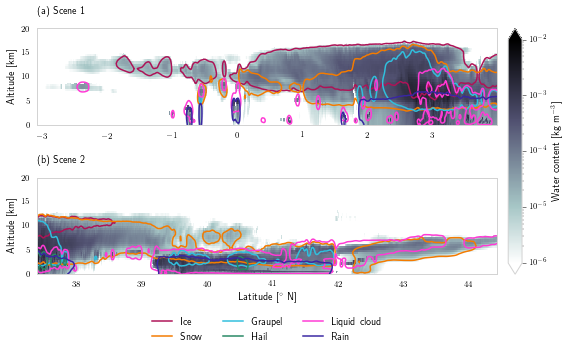

In [16]:
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib.cm import bone_r
from scipy.ndimage import gaussian_filter
from matplotlib.lines import Line2D

f = plt.figure(figsize = (8, 5))
gs = GridSpec(3, 2, width_ratios = [1.0, 0.03], height_ratios = [1.0, 1.0, 0.05])
norm = LogNorm(1e-6, 1e-2)
cmap = bone_r

#
# First scene
#

ax = plt.subplot(gs[0, 0])
x  = reference_a["lat"]
y  = reference_a["z"] / 1e3
z  = sum(hmcs[0]).T



handles_l = []
# Melting layer
t = reference_a["temperature"]
z_fl = np.zeros(800)
for i in range(800):
    ind = np.where(t[i, :] < 273.15)[0][0]
    z_fl[i] = 0.5 * (y[ind] + y[ind-1])
# Tropopause
z_tp = np.zeros(800)
for i in range(800):
    ti = t[i, :]
    t_avg = 0.5 * (ti[1:] + ti[:-1])
    lr    = - np.diff(ti)
    tp = np.where(np.logical_and(lr < 0, t_avg < 220))[0]
    inds  = np.ones(ti.size, dtype = np.bool)
    if len(tp > 0):
        j     = np.where(np.logical_and(lr < 0, t_avg < 220))[0][0]
        inds[j : inds.size] = False
    ind = np.where(~inds)[0][0]
    z_tp[i] = 0.5 * (y[ind] + y[ind + 1])
#handles_l += ax.plot(x, z_fl, ls = "--", c = "k", lw=1)
#handles_l += ax.plot(x, z_tp, ls = "-.", c = "k", lw=1)


ax.pcolormesh(x, y, z, norm = norm, cmap = cmap)
for i, z in enumerate(hmcs[0]):
    if z.max() > 1e-5:
        z = gaussian_filter(z, 1.5)
        ax.contour(x, y, z.T, levels = [1e-5], colors = ["C{}".format(i)], linewidths = [1.5])
        
ax.set_title("(a) Scene 1", loc = "left")
ax.set_ylim([0, 20])
ax.set_ylabel("Altitude [km]")
    
#
# Second scene
#

ax = plt.subplot(gs[1, 0])
x  = reference_b["lat"]
y  = reference_b["z"] / 1e3
z  = sum(hmcs[1]).T

# Melting layer
t = reference_b["temperature"]
z_fl = np.zeros(800)
for i in range(800):
    ind = np.where(t[i, :] < 273.15)[0][0]
    z_fl[i] = 0.5 * (y[ind] + y[ind-1])
# Tropopause
z_tp = np.zeros(800)
for i in range(800):
    ti = t[i, :]
    t_avg = 0.5 * (ti[1:] + ti[:-1])
    lr    = - np.diff(ti)
    tp = np.where(np.logical_and(lr < 0, t_avg < 220))[0]
    inds  = np.ones(ti.size, dtype = np.bool)
    if len(tp > 0):
        j     = np.where(np.logical_and(lr < 0, t_avg < 220))[0][0]
        inds[j : inds.size] = False
    ind = np.where(~inds)[0][0]
    z_tp[i] = 0.5 * (y[ind] + y[ind + 1])

img = ax.pcolormesh(x, y, z, norm = norm, cmap = cmap)
#ax.plot(x, z_fl, ls = "--", c = "k", lw=1)
#ax.plot(x, z_tp, ls = "-.", c = "k", lw=1)
for i, z in enumerate(hmcs[1]):
    if z.max() > 1e-5:
        z = gaussian_filter(z, 1.5)
        ax.contour(x, y, z.T, levels = [1e-5], colors = ["C{}".format(i)], linewidths = [1.5])
        
ax.set_title("(b) Scene 2", loc = "left")
ax.set_ylim([0, 20])
ax.set_ylabel("Altitude [km]")
ax.set_xlabel(r"Latitude [$^\circ \ \text{N}$]")

    
#
# Color bar
#

ax = plt.subplot(gs[:2, 1])
plt.colorbar(img, cax = ax, label = "Water content [kg m$^{-3}$]", extend = "both")

#
# Legend
#

labels = ["Ice", "Snow", "Graupel", "Hail", "Liquid cloud", "Rain"]
handles = [Line2D([0.0], [0.0], c = "C{}".format(i)) for i in range(len(labels))]

ax = plt.subplot(gs[2, :1])
ax.set_axis_off()
ax.legend(labels = labels, handles = handles, ncol = 3, loc = "center")

plt.tight_layout()
f.savefig("../../plots/scene_overview.png", dpi = 300, bbox_inches = "tight")

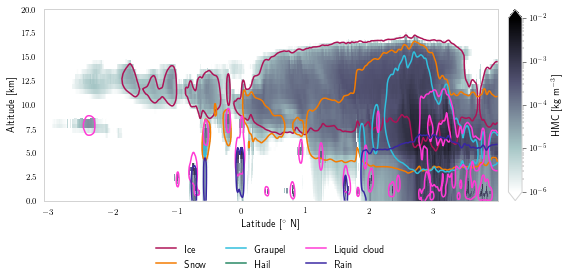

In [161]:
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib.cm import bone_r
from scipy.ndimage import gaussian_filter
from matplotlib.lines import Line2D

f = plt.figure(figsize = (8, 4))
gs = GridSpec(2, 2, width_ratios = [1.0, 0.03], height_ratios = [1.0, 0.05])
norm = LogNorm(1e-6, 1e-2)
cmap = bone_r

#
# First scene
#

ax = plt.subplot(gs[0, 0])
x  = reference_a["lat"]
y  = reference_a["z"] / 1e3
z  = sum(hmcs[0]).T

ax.pcolormesh(x, y, z, norm = norm, cmap = cmap)
for i, z in enumerate(hmcs[0]):
    if z.max() > 1e-5:
        z = gaussian_filter(z, 1.5)
        ax.contour(x, y, z.T, levels = [1e-5], colors = ["C{}".format(i)], linewidths = [1.5])
        
#ax.set_title("(a) Scene 1", loc = "left")
ax.set_ylim([0, 20])
ax.set_ylabel("Altitude [km]")
ax.set_xlabel(r"Latitude [$^\circ \ \text{N}$]")

    
#
# Color bar
#

ax = plt.subplot(gs[:1, 1])
plt.colorbar(img, cax = ax, label = "HMC [kg m$^{-3}$]", extend = "both")

#
# Legend
#

labels = ["Ice", "Snow", "Graupel", "Hail", "Liquid cloud", "Rain"]
handles = [Line2D([0.0], [0.0], c = "C{}".format(i)) for i in range(len(labels))]

ax = plt.subplot(gs[1, :1])
ax.set_axis_off()
ax.legend(labels = labels, handles = handles, ncol = 3, loc = "center")

plt.tight_layout()
f.savefig("../../plots/scene_one_overview.png", dpi = 300, bbox_inches = "tight")

## Particle size distributions

In [162]:
def get_ssa_gci(f):
    data = gci_d
    ssa = np.zeros(len(data))
    for i in range(ssa.size):
        f_grid = data[i].f_grid
        extinction = np.interp(np.array(f), f_grid, data[i].ext_mat_data[:, 0, 0, 0, 0])
        absorption = np.interp(np.array(f), f_grid, data[i].abs_vec_data[:, 0, 0, 0, 0])
        ssa[i] = (extinction - absorption) / extinction
    return ssa

def get_ssa_gs(f):
    data = gs_d
    ssa = np.zeros(len(data))
    for i in range(ssa.size):
        f_grid = data[i].f_grid
        extinction = np.interp(np.array(f), f_grid, data[i].ext_mat_data[:, 0, 0, 0, 0])
        absorption = np.interp(np.array(f), f_grid, data[i].abs_vec_data[:, 0, 0, 0, 0])
        ssa[i] = (extinction - absorption) / extinction
    return ssa

def get_ssa(h, f):
    ssa = np.zeros(len(h.data))
    for i in range(ssa.size):
        f_grid = h.data[i].f_grid
        extinction = np.interp(np.array(f), f_grid, h.data[i].ext_mat_data[:, 0, 0, 0, 0])
        absorption = np.interp(np.array(f), f_grid, h.data[i].abs_vec_data[:, 0, 0, 0, 0])
        ssa[i] = (extinction - absorption) / extinction
    return ssa

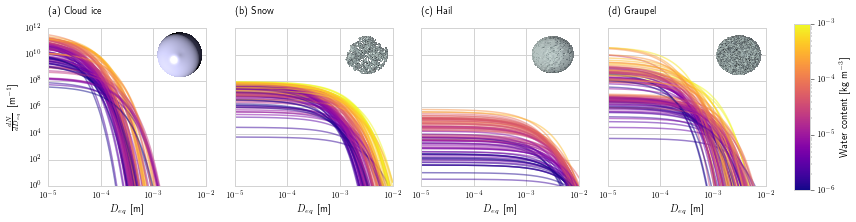

In [163]:
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable, plasma
from matplotlib.gridspec import GridSpec
from parts.scattering.psd.my05 import MY05
from mcrf.liras import liras_path
import matplotlib.image as mpimage

sm = ScalarMappable(cmap = plasma, norm = LogNorm(1e-6, 1e-3))
sm.set_array(np.logspace(-6, -3, 101))

psds = [MY05(hydrometeor_type = s) for s in ["cloud_ice", "snow", "hail", "graupel"]]
qs_a = [(reference_a[k], reference_a[k + "_nd"]) for k in ["iwc", "swc", "hwc", "gwc"]]
qs_b = [(reference_b[k], reference_b[k + "_nd"]) for k in ["iwc", "swc", "hwc", "gwc"]]
x = np.logspace(-5, -2, 201)

f = plt.figure(figsize = (12, 3))
gs = GridSpec(1, 5, width_ratios = [1.0] * 4 + [0.1])
titles = ["(a) Cloud ice", "(b) Snow", "(c) Hail", "(d) Graupel"]
shape_images = ["gem_cloud_ice", "gem_snow",
                "gem_hail", "gem_graupel"]

for i, (psd, q_a, q_b) in enumerate(zip(psds, qs_a, qs_b)):
    
    ax = plt.subplot(gs[i])
    
    for j in range(100):
        if np.random.rand() >= 0.5:
            q = q_a
        else:
            q = q_b

        inds = np.where(q[0] > 1e-6)
        
        if len(inds[0]) == 0:
            if np.random.rand() >= 0.5:
                q = q_b
            else:
                q = q_a
            inds = np.where(q[0] > 1e-6)
        
        if len(inds[0]) > 0:
            ind = np.random.randint(len(inds[0]))

            i1, i2 = inds[0][ind], inds[1][ind]
            md = q[0][i1, i2]
            nd = q[1][i1, i2]
            psd.mass_density = np.array([md])
            psd.number_density = np.array([nd])
            c = sm.to_rgba(md)

            y = psd.evaluate(x).data.ravel()
    
            ax.plot(x, y, c = c, alpha = 0.5)
        
    im = mpimage.imread(os.path.join(liras_path, "data", shape_images[i] + "_shape.png"))
    
    xx = np.logspace(-3, -2, im.shape[0] + 1)
    yy = np.logspace(8, 12, im.shape[1] + 1)
    #xx, yy = np.meshgrid(xx, yy)
    
    im = np.transpose(im, axes = [1, 0, 2])
    cs = np.zeros((im.shape[0] * im.shape[1], 4))
    cs[:, 0] = im[:, :, 0].ravel()
    cs[:, 1] = im[:, :, 1].ravel()
    cs[:, 2] = im[:, :, 2].ravel()
    cs[:, 3] = im[:, :, 3].ravel()
    
    img = ax.pcolormesh(xx, yy, im[:, :, 0], color = cs)
    img.set_array(None)
    
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    ax.set_ylim([1, 1e12])
    ax.set_xlim([1e-5, 1e-2])
    ax.set_title(titles[i], loc = "left")
    ax.set_aspect(0.25)
    
    if i == 0:
        ax.set_ylabel(r"$\frac{dN}{dD_{eq}}$ [m$^{-1}$]")
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])
            
    ax.set_xlabel("$D_{eq}$ [m]")
    ax.grid(True)
    
    
# Colorbar
ax = plt.subplot(gs[-1])
plt.colorbar(sm, cax = ax, label = "Water content [kg m$^{-3}$]")
plt.tight_layout()
f.savefig("../../plots/gem_psds.png", dpi = 300)

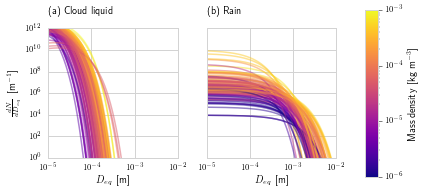

In [164]:
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable, plasma
from matplotlib.gridspec import GridSpec
from parts.scattering.psd.my05 import MY05
from mcrf.liras import liras_path
import matplotlib.image as mpimage

sm = ScalarMappable(cmap = plasma, norm = LogNorm(1e-6, 1e-3))
sm.set_array(np.logspace(-6, -3, 101))

psds = [MY05(hydrometeor_type = s) for s in ["cloud_water", "rain"]]
qs_a = [(reference_a[k], reference_a[k + "_nd"]) for k in ["lwc", "rwc"]]
qs_b = [(reference_b[k], reference_b[k + "_nd"]) for k in ["lwc", "rwc"]]
x = np.logspace(-5, -2, 201)

plt.figure(figsize = (6, 3))
gs = GridSpec(1, 3, width_ratios = [1.0] * 2 + [0.1])
titles = ["(a) Cloud liquid", "(b) Rain"]

for i, (psd, q_a, q_b) in enumerate(zip(psds, qs_a, qs_b)):
    
    ax = plt.subplot(gs[i])
    
    for j in range(100):
        if np.random.rand() >= 0.5:
            q = q_a
        else:
            q = q_b

        inds = np.where(q[0] > 1e-6)
        
        if len(inds[0]) == 0:
            if np.random.rand() >= 0.5:
                q = q_b
            else:
                q = q_a
            inds = np.where(q[0] > 1e-6)
        
        if len(inds[0]) > 0:
            ind = np.random.randint(len(inds[0]))

            i1, i2 = inds[0][ind], inds[1][ind]
            md = q[0][i1, i2]
            nd = q[1][i1, i2]
            psd.mass_density = np.array([md])
            psd.number_density = np.array([nd])
            c = sm.to_rgba(md)

            y = psd.evaluate(x).data.ravel()
    
            ax.plot(x, y, c = c, alpha = 0.5)
        
    img.set_array(None)
    
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    ax.set_ylim([1, 1e12])
    ax.set_xlim([1e-5, 1e-2])
    ax.set_title(titles[i], loc = "left")
    ax.set_aspect(0.25)
    
    if i == 0:
        ax.set_ylabel(r"$\frac{dN}{dD_{eq}}$ [m$^{-1}$]")
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])
            
    ax.set_xlabel("$D_{eq}$ [m]")
    ax.grid(True)
    
    
# Colorbar
ax = plt.subplot(gs[-1])
plt.colorbar(sm, cax = ax, label = "Mass density [kg m$^{-3}$]")
plt.tight_layout()
f.savefig("../../plots/gem_psds_liquid.png", dpi = 300)

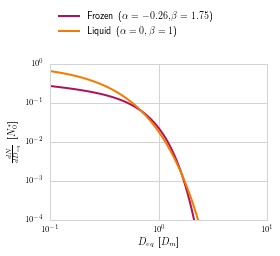

In [165]:
from matplotlib.cm import plasma
from mcrf.liras import ice, rain

rain.psd.alpha = 0.0

cs = [plasma(0), plasma(200)]
f, ax = plt.subplots(1, 1, figsize = (4, 4))

x = np.logspace(-1, 1, 101)

labels = [r"Frozen ($\alpha = -0.26, \beta = 1.75$)",
          r"Liquid ($\alpha = 0, \beta = 1$)"]

for i, s in enumerate([ice, rain]):
    c = cs[i]
    
    psd = s.psd
    setattr(psd, "intercept_parameter", np.ones(1))
    setattr(psd, "mass_weighted_diameter", np.ones(1))
    
    y = psd.evaluate(x).data.ravel()
    ax.plot(x, y, label = labels[i], lw = 2)
    
ax.set_ylabel(r"$\frac{dN}{dD_{eq}}$ [$N_0^*$]")
ax.set_xlabel(r"$D_{eq}$ [$D_m$]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([1e-4, 1e0])
ax.set_xlim([1e-1, 1e1])
ax.legend(loc = "upper left", bbox_to_anchor = [0.0, 1.4])

plt.tight_layout()

f.savefig("../../plots/psds_retrieval.pdf", bbox_inches = "tight")

In [166]:
from arts.xml import load
data = load("/home/simonpf/Dendrite/SSDB/ArtsScatDbase/ArtsScatDbase_v1.0.0/StandardHabits/FullSet/LargePlateAggregate.xml")
d = data[0]
theta = d.za_grid
ff = d.pha_mat_data[0, 0, :, 0, 0, 0, 0]
fi = np.trapz(np.sin(np.deg2rad(theta)) * ff * 2 * np.pi, x = np.deg2rad(theta))
a = d.abs_vec_data[0, 0, 0, 0, 0]
e = d.ext_mat_data[0, 0, 0, 0, 0]
(e - a) / fi

1.0000000010268486

## Particle properties

In [167]:
from joint_flight.data import habits

hs_robin = ["8-ColumnAggregate", "EvansSnowAggregate", "IconCloudIce",
          "IconSnow", "LargeBlockAggregate", "LargePlateAggregate",
          "SectorSnowflake", "dardar-spheroid"]
hs_gem = ["GemSnow", "GemCloudIce", "GemGraupel", "GemHail"]
hs_s = ["LargePlateAggregate", "LargeColumnAggregate"]

bs_94 = {}
ext_94 = {}
ext_325 = {}
ext_183 = {}
ext_664 = {}

hs = hs_robin + hs_gem + hs_s
fs = dict([(h, {}) for h in hs])

for h in hs:
    hb = getattr(habits, h)

    n = hb.de.size
    e_1 = np.zeros(n)
    e_2 = np.zeros(n)
    e_3 = np.zeros(n)

    df = 1e13
    f0 = 94
    x = np.zeros(n)
    for i in range(n):
        i_f = np.argmin(np.abs(hb.data[i].f_grid - 94 * 1e9))
        df2 = np.abs(hb.data[i].f_grid[i_f] - f0)
        if (df2 < df):
            f = hb.data[i].f_grid[i_f]
            df = df2
        i_t = np.argmin(np.abs(hb.data[i].T_grid - 230))
        x[i] = hb.data[i].pha_mat_data[i_f, i_t, -1, 0, 0, 0, 0]
        tg = hb.data[i].za_grid
        
    bs_94[h] = x
    fs[h]["94"] = hb.data[i].f_grid[i_f]
    
    f = 1e13
    x = np.zeros(n)
    for i in range(n):
        i_f = np.argmin(np.abs(hb.data[i].f_grid - 94 * 1e9))
        df2 = np.abs(hb.data[i].f_grid[i_f] - f0 * 1e9)
        if (df2 < df):
            f = hb.data[i].f_grid[i_f]
            df = df2
        i_t = np.argmin(np.abs(hb.data[i].T_grid - 230))
        x[i] = hb.data[i].ext_mat_data[i_f, i_t, 0, 0, 0]
    ext_94[h] = x

    df = 1e13
    f0 = 183
    x = np.zeros(n)
    for i in range(n):
        i_f = np.argmin(np.abs(hb.data[i].f_grid - 183 * 1e9))
        df2 = np.abs(hb.data[i].f_grid[i_f] - f0)
        if (df2 < df):
            f = hb.data[i].f_grid[i_f]
            df = df2
        i_t = np.argmin(np.abs(hb.data[i].T_grid - 230))
        x[i] = hb.data[i].ext_mat_data[i_f, i_t, 0, 0, 0]
    ext_183[h] = x
    fs[h]["183"] = hb.data[i].f_grid[i_f]

    df = 1e13
    f0 = 325
    x = np.zeros(n)
    for i in range(n):
        i_f = np.argmin(np.abs(hb.data[i].f_grid - 325 * 1e9))
        df2 = np.abs(hb.data[i].f_grid[i_f] - f0 * 1e9)
        if (df2 < df):
            f = hb.data[i].f_grid[i_f]
            df = df2
        x[i] = hb.data[i].ext_mat_data[i_f, -1, 0, 0, 0]
    ext_325[h] = x
    fs[h]["325"] = f

    x = np.zeros(n)
    df = 1e13
    f0 = 664
    for i in range(n):
        i_f = np.argmin(np.abs(hb.data[i].f_grid - f0 * 1e9))
        df2 = np.abs(hb.data[i].f_grid[i_f] - f0 * 1e9)
        if (df2 < df):
            f = hb.data[i].f_grid[i_f]
            df = df2
        x[i] = hb.data[i].ext_mat_data[i_f, -1, 0, 0, 0]
    ext_664[h] = x
    fs[h]["664"] = f

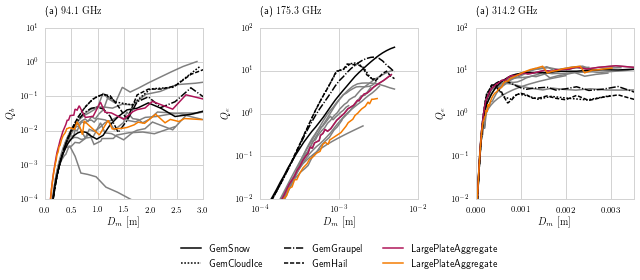

In [168]:
from matplotlib.gridspec import GridSpec
from scipy.constants import speed_of_light
f = plt.figure(figsize = (9, 4))
gs = GridSpec(2, 3, height_ratios = [1.0, 0.2])

ax_1 = plt.subplot(gs[0, 0])
ax_2 = plt.subplot(gs[0, 1])
ax_3 = plt.subplot(gs[0, 2])
#ax_4 = plt.subplot(gs[1, 1])

gem_ls = ["-", ":", "-.", "--"]

for h in hs_robin:
    hb = getattr(habits, h)
    lbd = speed_of_light / (94.1 * 1e9)
    x = np.pi * hb.de / lbd
    #x = hb.de
    ax_1.plot(x,
              4 * bs_94[h] / (hb.de ** 2),
              c = "grey")
    lbd = speed_of_light / (183 * 1e9)
    x = np.pi * hb.de / lbd
    x = hb.de
    ax_2.plot(x,
              4 * ext_183[h] / (np.pi * hb.de ** 2),
              c = "grey")
    lbd = speed_of_light / (664 * 1e9)
    x = np.pi * hb.de / lbd
    x = hb.de
    ax_3.plot(x,
              4 * ext_664[h] / (np.pi * hb.de ** 2),
              c = "grey")
    x = hb.dmax
    #ax_4.plot(x,
    #          hb.m,
    #          c = "grey")
    
labels = []
handles = []

for i, h in enumerate(hs_gem):
    hb = getattr(habits, h)
    lbd = speed_of_light / (94.1 * 1e9)
    x = np.pi * hb.de / lbd
    ax_1.plot(x,
              4 * bs_94[h] / (hb.de ** 2),
              c = "k",
              label = h,
             ls = gem_ls[i])
    lbd = speed_of_light / (183 * 1e9)
    x = np.pi * hb.de / lbd
    x = hb.de
    handles += ax_2.plot(x,
                         4 * ext_183[h] / (hb.de ** 2),
                         c = "k",
                         label = h,
                         ls = gem_ls[i])
    
    labels += [h]
    lbd = speed_of_light / (664 * 1e9)
    x = np.pi * hb.de / lbd
    x = hb.de
    ax_3.plot(x,
              4 * ext_664[h] / (np.pi * hb.de ** 2),
              c = "k",
              label = h,
             ls = gem_ls[i])
    #x = hb.dmax
    #ax_4.plot(x,
    #          hb.m,
    #          c = "k",
    #          label = h,
    #         ls = gem_ls[i])
    
    
for i, h in enumerate(hs_s):
    hb = getattr(habits, h)
    lbd = speed_of_light / (94.1 * 1e9)
    x = np.pi * hb.de / lbd
    #x = hb.de
    ax_1.plot(x,
              4 * np.pi * 4 * bs_94[h] / (np.pi * hb.de ** 2),
              label = h)
    lbd = speed_of_light / (183 * 1e9)
    x = np.pi * hb.de / lbd
    x = hb.de
    handles += ax_2.plot(x,
                         4 * ext_183[h] / (np.pi * hb.de ** 2),
                         label = h)
    labels += [h]
    
    lbd = speed_of_light / (664 * 1e9)
    x = hb.de
    ax_3.plot(x,
              4 * ext_664[h] / (np.pi * hb.de ** 2),
              label = h)
    labels += [h]
    #x = hb.dmax
    #ax_4.plot(x,
    #          hb.m,
    #          label = h)
    
ax_1.set_yscale("log")
#ax_1.set_xscale("log")
ax_1.set_xlabel(r"$D_m\ [\unit{m}]$")
ax_1.set_ylabel("$Q_b$")
ax_1.set_title(r"(a) ${:2}\ \unit{{GHz}}$".format(fs["LargePlateAggregate"]["94"] / 1e9), loc = "left")
ax_1.set_xlim([0, 3])
ax_1.set_ylim([1e-4, 1e1])

ax_2.set_yscale("log")
ax_2.set_xscale("log")
ax_2.set_xlim([1e-4, 1e-2])
ax_2.set_ylim([1e-2, 1e2])
ax_2.set_xlabel(r"$D_m\ [\unit{m}]$")
ax_2.set_ylabel("$Q_e$")
ax_2.set_title(r"(a) ${:2}\ \unit{{GHz}}$".format(fs["LargePlateAggregate"]["183"] / 1e9), loc = "left")

ax_3.set_yscale("log")
#ax_3.set_xscale("log")
ax_3.set_xlim([1e-4, 1e-2])
ax_3.set_xlim([0, 3500e-6])
ax_3.set_ylim([1e-2, 1e2])
ax_3.set_xlabel(r"$D_m\ [\unit{m}]$")
ax_3.set_ylabel("$Q_e$")
ax_3.set_title(r"(c) $664\ \unit{GHz}$", loc = "left")
ax_3.set_title(r"(a) ${:2}\ \unit{{GHz}}$".format(fs["LargePlateAggregate"]["325"] / 1e9), loc = "left")

ax_l = plt.subplot(gs[1, :])
ax_l.set_axis_off()
ax_l.legend(handles = handles,
            labels = labels,
            loc = "center",
            ncol = 3)

ax.legend()
    
ax.set_xscale("log")
ax.set_yscale("log")

plt.tight_layout()
f.savefig("../../plots/particle_properties.pdf",
          bbox_inches = "tight")

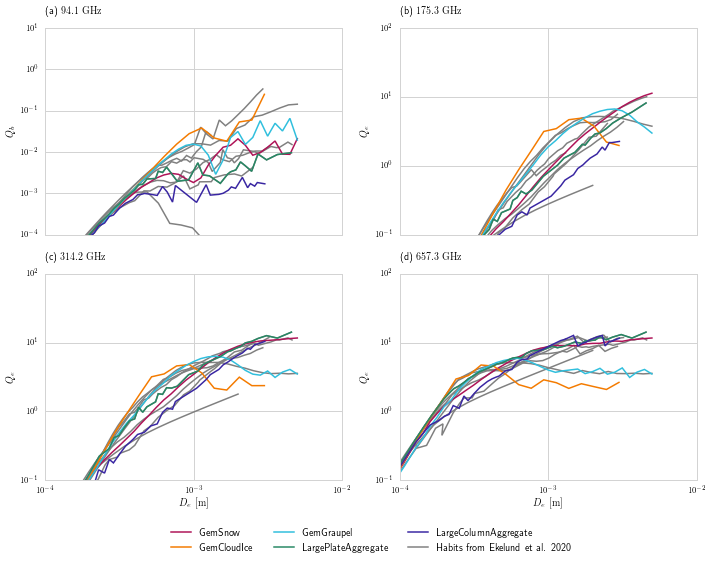

In [169]:
from matplotlib.gridspec import GridSpec
from scipy.constants import speed_of_light
f = plt.figure(figsize = (10, 8))
gs = GridSpec(3, 2, height_ratios = [1.0, 1.0, 0.2])

ax_1 = plt.subplot(gs[0, 0])
ax_2 = plt.subplot(gs[0, 1])
ax_3 = plt.subplot(gs[1, 0])
ax_4 = plt.subplot(gs[1, 1])

gem_ls = ["-", "-", "-", "-"]
markers = ["", "", "", "", "", ""]
gem_cs = ["C0", "C1", "C2"]
cs = ["C3", "C5"]


for h in hs_robin:
    hb = getattr(habits, h)
    lbd = speed_of_light / (94 * 1e9)
    x = np.pi * hb.de / lbd
    x = hb.de
    ax_1.plot(x,
              4 * bs_94[h] / (np.pi * hb.de ** 2),
              c = "grey")
    lbd = speed_of_light / (183 * 1e9)
    x = np.pi * hb.de / lbd
    x = hb.de
    ax_2.plot(x,
              4 * ext_183[h] / (np.pi * hb.de ** 2),
              c = "grey")
    x = hb.de
    ax_3.plot(x,
              4 * ext_325[h] / (np.pi * hb.de ** 2),
              c = "grey")
    lbd = speed_of_light / (664 * 1e9)
    x = np.pi * hb.de / lbd
    x = hb.de
    ls = ax_4.plot(x,
                  4 * ext_664[h] / (np.pi * hb.de ** 2),
                  c = "grey")
    x = hb.dmax
    #ax_4.plot(x,
    #          hb.m,
    #          c = "grey")
    
labels = ["Habits from Ekelund et al., 2020"]
handles = []
labels = []

for i, h in enumerate(hs_gem[:-1]):
    hb = getattr(habits, h)
    x = hb.de
    ax_1.plot(x, 4 * bs_94[h] / (np.pi * hb.de ** 2), c = gem_cs[i], label = h, marker = markers[i], lw = 1.5, ls = gem_ls[i])
    handles += ax_2.plot(x, 4 * ext_183[h] / (np.pi * hb.de ** 2), c = gem_cs[i], label = h, marker = markers[i], lw = 1.5, ls = gem_ls[i])
    labels += [h]
    ax_3.plot(x, 4 * ext_325[h] / (np.pi * hb.de ** 2), c = gem_cs[i], lw = 1.5, label = h, ls = gem_ls[i])
    ax_4.plot(x, 4 * ext_664[h] / (np.pi * hb.de ** 2), c = gem_cs[i], lw = 1.5, label = h, ls = gem_ls[i])
    
    
for i, h in enumerate(hs_s):
    hb = getattr(habits, h)
    lbd = speed_of_light / (664 * 1e9)
    
    x = hb.de
    ax_1.plot(x, 4 * bs_94[h] / (np.pi * hb.de ** 2), label = h, lw = 1.5, c = cs[i])
    lbd = speed_of_light / (183 * 1e9)
    
    x = hb.de
    handles += ax_2.plot(x, 4 * ext_183[h] / (np.pi * hb.de ** 2), label = h, lw = 1.5, c = cs[i])
    labels += [h]
    
    x = hb.de
    ax_3.plot(x, 4 * ext_325[h] / (np.pi * hb.de ** 2), lw = 1.5, c = cs[i])
    ax_4.plot(x, 4 * ext_664[h] / (np.pi * hb.de ** 2), lw = 1.5, label = h, c = cs[i])
    
handles += ls
labels += ["Habits from Ekelund et al. 2020"]

ax_1.set_yscale("log")
ax_1.set_xscale("log")
ax_1.set_ylabel("$Q_b$")
ax_1.set_xticklabels([])
ax_1.set_title(r"(a) ${:2}\ \unit{{GHz}}$".format(fs["LargePlateAggregate"]["94"] / 1e9), loc = "left")
ax_1.set_xlim([1e-4, 1e-2])
ax_1.set_ylim([1e-4, 1e1])

ax_2.set_yscale("log")
ax_2.set_xscale("log")
ax_2.set_xticklabels([])
ax_2.set_xlim([1e-4, 1e-2])
ax_2.set_ylim([1e-1, 1e2])
ax_2.set_ylabel("$Q_e$")
ax_2.set_title(r"(b) ${:2}\ \unit{{GHz}}$".format(fs["LargePlateAggregate"]["183"] / 1e9), loc = "left")

ax_3.set_yscale("log")
ax_3.set_xscale("log")
ax_3.set_xlim([1e-4, 1e-2])
ax_3.set_ylim([1e-1, 1e2])
ax_3.set_xlabel(r"$D_e\ [\unit{m}]$")
ax_3.set_ylabel("$Q_e$")
ax_3.set_title(r"(c) ${:2}\ \unit{{GHz}}$".format(fs["LargePlateAggregate"]["325"] / 1e9), loc = "left")

ax_4.set_yscale("log")
ax_4.set_xscale("log")
ax_4.set_xlabel(r"$D_e\ [\unit{m}]$")
ax_4.set_ylabel("$Q_e$")
ax_4.set_xlim([1e-4, 1e-2])
ax_4.set_title(r"(d) ${:2}\ \unit{{GHz}}$".format(fs["LargePlateAggregate"]["664"] / 1e9), loc = "left")
ax_4.set_ylim([1e-1, 1e2])

ax_l = plt.subplot(gs[2, :])
ax_l.set_axis_off()
ax_l.legend(handles = handles,
            labels = labels,
            loc = "center",
            ncol = 3)
    
ax.set_xscale("log")
ax.set_yscale("log")

plt.tight_layout()
f.savefig("../../plots/particle_properties.pdf",
          bbox_inches = "tight")

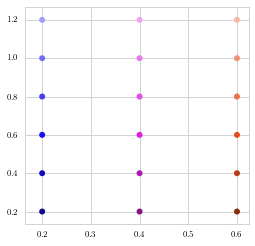

In [173]:
from matplotlib.cm import plasma
from seaborn import set_hls_values
c1 = plasma(0/3)
cs1 = [set_hls_values(c1, l = l) for l in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]]
c2 = plasma(1/3)
cs2 = [set_hls_values(c2, l = l) for l in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]]
c3 = plasma(2/3)
cs3 = [set_hls_values(c3, l = l) for l in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]]

f, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.scatter([0.2] * 6, [0.2 + x for x in np.linspace(0, 1, 6)], c = cs1)
ax.scatter([0.4] * 6, [0.2 + x for x in np.linspace(0, 1, 6)], c = cs2)
ax.scatter([0.6] * 6, [0.2 + x for x in np.linspace(0, 1, 6)], c = cs3)

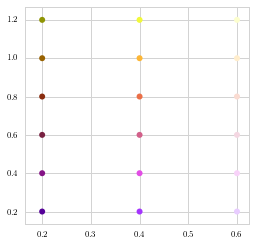

In [171]:
from matplotlib.cm import plasma
from seaborn import set_hls_values
c1 = plasma(0/3)
cs1 = [set_hls_values(c, l = 0.3) for c in plasma(np.linspace(0, 1, 7)[1:])]
c2 = plasma(1/3)
cs2 = [set_hls_values(c, l = 0.6) for c in plasma(np.linspace(0, 1, 7)[1:])]
c3 = plasma(2/3)
cs3 = [set_hls_values(c, l = 0.9) for c in plasma(np.linspace(0, 1, 7)[1:])]

f, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.scatter([0.2] * 6, [0.2 + x for x in np.linspace(0, 1, 6)], c = cs1)
ax.scatter([0.4] * 6, [0.2 + x for x in np.linspace(0, 1, 6)], c = cs2)
ax.scatter([0.6] * 6, [0.2 + x for x in np.linspace(0, 1, 6)], c = cs3)

In [174]:
from parts.scattering.psd.d14 import D14MN

psd = D14MN(alpha=-0.262, beta=1.754)

n = 11 * 18
m = np.logspace(-6, -3, n)

bs_94_6 = {}
bs_94_9 = {}
bs_94_12 = {}

for h in bs_94:
    hb = getattr(habits, h)
    bs = bs_94[h]
    
    psd.mass_density = m
    psd.intercept_parameter = 1e6 * np.ones(n)
    y = psd.evaluate(hb.de).data
    bs_94_6[h] = np.trapz(y * bs, x = hb.de)
    
    psd.intercept_parameter = 1e8 * np.ones(n)
    y = psd.evaluate(hb.de).data
    bs_94_9[h] = np.trapz(y * bs, x = hb.de)
    
    psd.intercept_parameter = 1e10 * np.ones(n)
    y = psd.evaluate(hb.de).data
    bs_94_12[h] = np.trapz(y * bs, x = hb.de)
    
ext_94_6 = {}
ext_94_9 = {}
ext_94_12 = {}

for h in ext_94:
    hb = getattr(habits, h)
    ext = ext_94[h]
    
    psd.mass_density = m
    psd.intercept_parameter = 1e6 * np.ones(n)
    y = psd.evaluate(hb.de).data
    ext_94_6[h] = np.trapz(y * ext, x = hb.de)
    
    psd.intercept_parameter = 1e8 * np.ones(n)
    y = psd.evaluate(hb.de).data
    ext_94_9[h] = np.trapz(y * ext, x = hb.de)
    
    psd.intercept_parameter = 1e10 * np.ones(n)
    y = psd.evaluate(hb.de).data
    ext_94_12[h] = np.trapz(y * ext, x = hb.de)
    
ext_183_6 = {}
ext_183_9 = {}
ext_183_12 = {}
    
for h in ext_183:
    hb = getattr(habits, h)
    ext = ext_183[h]
    
    psd.mass_density = m
    psd.intercept_parameter = 1e6 * np.ones(n)
    y = psd.evaluate(hb.de).data
    ext_183_6[h] = np.trapz(y * ext, x = hb.de)
    
    psd.intercept_parameter = 1e8 * np.ones(n)
    y = psd.evaluate(hb.de).data
    ext_183_9[h] = np.trapz(y * ext, x = hb.de)
    
    psd.intercept_parameter = 1e10 * np.ones(n)
    y = psd.evaluate(hb.de).data
    ext_183_12[h] = np.trapz(y * ext, x = hb.de)
    
ext_325_6 = {}
ext_325_9 = {}
ext_325_12 = {}

for h in ext_325:
    hb = getattr(habits, h)
    ext = ext_325[h]
    
    psd.mass_density = m
    psd.intercept_parameter = 1e6 * np.ones(n)
    y = psd.evaluate(hb.de).data
    ext_325_6[h] = np.trapz(y * ext, x = hb.de)
    
    psd.intercept_parameter = 1e8 * np.ones(n)
    y = psd.evaluate(hb.de).data
    ext_325_9[h] = np.trapz(y * ext, x = hb.de)
    
    psd.intercept_parameter = 1e10 * np.ones(n)
    y = psd.evaluate(hb.de).data
    ext_325_12[h] = np.trapz(y * ext, x = hb.de)
    
ext_664_6 = {}
ext_664_9 = {}
ext_664_12 = {}
    
for h in ext_664:
    hb = getattr(habits, h)
    ext = ext_664[h]
    
    psd.mass_density = m
    psd.intercept_parameter = 1e6 * np.ones(n)
    y = psd.evaluate(hb.de).data
    ext_664_6[h] = np.trapz(y * ext, x = hb.de)
    
    psd.intercept_parameter = 1e8 * np.ones(n)
    y = psd.evaluate(hb.de).data
    ext_664_9[h] = np.trapz(y * ext, x = hb.de)
    
    psd.intercept_parameter = 1e10 * np.ones(n)
    y = psd.evaluate(hb.de).data
    ext_664_12[h] = np.trapz(y * ext, x = hb.de)

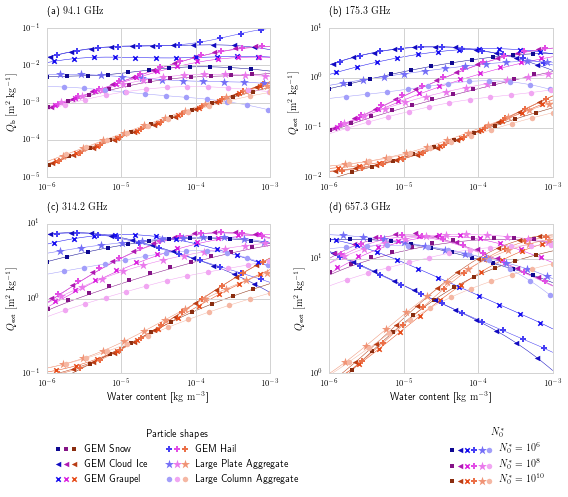

In [175]:
from matplotlib.gridspec import GridSpec
from matplotlib.legend_handler import HandlerTuple
from scipy.constants import speed_of_light
f = plt.figure(figsize = (8, 7))
gs = GridSpec(3, 2, height_ratios = [1.0, 1.0, 0.2])

ax_1 = plt.subplot(gs[0, 0])
ax_2 = plt.subplot(gs[0, 1])
ax_3 = plt.subplot(gs[1, 0])
ax_4 = plt.subplot(gs[1, 1])

qs_6  = [bs_94_6, ext_183_6, ext_325_6, ext_664_6]
qs_9  = [bs_94_9, ext_183_9, ext_325_9, ext_664_9]
qs_12 = [bs_94_12, ext_183_12, ext_325_12, ext_664_12]

axs = [ax_1, ax_2, ax_3, ax_4]
markers = ["s", "<", "x", "+", "*", "o"]
markers = ["s", "<", "x", "P", "*", "o"]
sizes = [20, 30, 20, 30, 90, 30]

x = np.logspace(-6, -3, n)
for h in hs_robin:
    for ax, q in zip(axs, qs_6):
        hb = getattr(habits, h)
        #ax.plot(x, q[h], c = "grey")
        
handles_n0 = [[], [], []]
handles_shapes = [[], [], [], [], [], []]

for i, h in enumerate(hs_gem):
    for ax, q in zip(axs, qs_6):
        hb = getattr(habits, h)
        h1 = ax.scatter(x[i*3::18], q[h][i*3::18] / x[i*3::18], c = [cs1[i]], marker = markers[i], s = sizes[i])
        ax.plot(x, q[h] / x, c = cs1[i], lw = 0.5, zorder = -20)
        
    for ax, q in zip(axs, qs_9):
        hb = getattr(habits, h)
        h2 = ax.scatter(x[i*3 + 1::18], q[h][i*3 + 2::18] / x[i*3 + 1::18], c = [cs2[i]], marker = markers[i], s = sizes[i])
        ax.plot(x, q[h] / x, c = cs2[i], lw = 0.5, zorder = -20)
        
    for ax, q in zip(axs, qs_12):
        hb = getattr(habits, h)
        h3 = handle = ax.scatter(x[i*3 + 2::18], q[h][i*3 + 2::18] / x[i*3 + 2::18], c = [cs3[i]], marker = markers[i], s = sizes[i])
        ax.plot(x, q[h] / x, c = cs3[i], lw = 0.5, zorder = -20)
        
    handles_shapes[i] += [h1, h2, h3]
    handles_n0[0] += [h1]
    handles_n0[1] += [h2]
    handles_n0[2] += [h3]
        
for i,h in enumerate(hs_s):
    for ax, q in zip(axs, qs_6):
        hb = getattr(habits, h)
        h1 = ax.scatter(x[(i + 4)*3::18], q[h][(i + 4)*3::18] / x[(i + 4)*3::18], c = [cs1[i + 4]], marker = markers[i + 4], s = sizes[i + 4])
        ax.plot(x, q[h] / x, c = cs1[i + 4], lw = 0.5, zorder = -20)
        
    for ax, q in zip(axs, qs_9):
        hb = getattr(habits, h)
        h2 = ax.scatter(x[(i + 4)*3 + 1::18], q[h][(i + 4)*3 + 1::18] / x[(i + 4)*3 + 1::18], c = [cs2[i + 4]], marker = markers[i + 4], s = sizes[i + 4])
        ax.plot(x, q[h] / x, c = cs2[i + 4], lw = 0.5, zorder = -20)
        
    for ax, q in zip(axs, qs_12):
        hb = getattr(habits, h)
        h3 = ax.scatter(x[(i + 4)*3 + 2::18], q[h][(i + 4)*3 + 2::18] / x[(i + 4)*3 + 2::18], c = [cs3[i + 4]], marker = markers[i + 4], s = sizes[i + 4])
        ax.plot(x, q[h] / x, c = cs3[i + 4], lw = 0.5, zorder = -20)
        
        
    handles_shapes[i + 4] += [h1, h2, h3]
    handles_n0[0] += [h1]
    handles_n0[1] += [h2]
    handles_n0[2] += [h3]
    
ax_1.set_yscale("log")
ax_1.set_xscale("log")
ax_1.set_xlim([1e-6, 1e-3])
ax_1.set_ylim([1e-5, 1e-1])
ax_1.set_ylabel(r"$Q_\text{b}\ [\unit{m^2\ kg^{-1}}]$")
ax_1.set_title(r"(a) ${:2}\ \unit{{GHz}}$".format(fs["LargePlateAggregate"]["94"] / 1e9), loc = "left")
        
ax_2.set_yscale("log")
ax_2.set_xscale("log")
ax_2.set_xlim([1e-6, 1e-3])
ax_2.set_ylim([1e-2, 1e1])
ax_2.set_ylabel(r"$Q_\text{ext}\ [\unit{m^2\ kg^{-1}}]$")
ax_2.set_title(r"(b) ${:2}\ \unit{{GHz}}$".format(fs["LargePlateAggregate"]["183"] / 1e9), loc = "left")

ax_3.set_yscale("log")
ax_3.set_xscale("log")
ax_3.set_xlim([1e-6, 1e-3])
ax_3.set_ylim([1e-1, 1e1])
ax_3.set_ylabel(r"$Q_\text{ext}\ [\unit{m^2\ kg^{-1}}]$")
ax_3.set_title(r"(c) ${:2}\ \unit{{GHz}}$".format(fs["LargePlateAggregate"]["325"] / 1e9), loc = "left")
ax_3.set_xlabel(r"Water content [$\unit{kg\ m^{-3}}$]")

ax_4.set_yscale("log")
ax_4.set_xscale("log")
ax_4.set_xlim([1e-6, 1e-3])
ax_4.set_ylim([1e0, 2 * 1e1])
ax_4.set_ylabel(r"$Q_\text{ext}\ [\unit{m^2\ kg^{-1}}]$")
ax_4.set_title(r"(d) ${:2}\ \unit{{GHz}}$".format(fs["LargePlateAggregate"]["664"] / 1e9), loc = "left")
ax_4.set_xlabel(r"Water content [$\unit{kg\ m^{-3}}$]")
        
        
ax = plt.subplot(gs[-1, :])
ax.set_axis_off()
labels = ["GEM Snow", "GEM Cloud Ice", "GEM Graupel", "GEM Hail", "Large Plate Aggregate", "Large Column Aggregate"]
handles_shapes = list(map(tuple, handles_shapes))
handler_map = dict(zip(handles_shapes, [HandlerTuple(ndivide=3)] * len(handles_shapes)))
l1 = ax.legend(title = "Particle shapes", handles = handles_shapes, labels = labels,
          handler_map = handler_map, ncol = 2, loc = "upper left")

#ax = plt.subplot(gs[-1, 1])
#ax.set_axis_off()
handles_n0 = list(map(tuple, handles_n0))
handler_map = dict(zip(handles_n0, [HandlerTuple(ndivide=6)] * len(handles_n0)))
labels = ["$N_0^* = 10^6$", "$N_0^* = 10^8$",  "$N_0^* = 10^{10}$"]
l2 = ax.legend(title = "$N_0^*$", handles = handles_n0, labels = labels,
          handler_map = handler_map, loc = "upper right", handlelength=4)
ax.add_artist(l1)

plt.tight_layout()
f.savefig("../../plots/particle_properties_d14.pdf", bbox_inches = "tight")

In [149]:
from joint_flight.data import habits

hs_robin = ["8-ColumnAggregate", "EvansSnowAggregate", "IconCloudIce",
          "IconSnow", "LargeBlockAggregate", "LargePlateAggregate",
          "SectorSnowflake", "dardar-spheroid"]
hs_gem = ["GemSnow", "GemCloudIce", "GemGraupel", "GemHail"]
hs_s = ["LargePlateAggregate", "LargeColumnAggregate"]

bs_94 = {}
ext_94 = {}
ext_325 = {}
ext_183 = {}
ext_664 = {}

hs = hs_robin + hs_gem + hs_s
fs = dict([(h, {}) for h in hs])

for h in hs:
    hb = getattr(habits, h)

    n = hb.de.size
    e_1 = np.zeros(n)
    e_2 = np.zeros(n)
    e_3 = np.zeros(n)

    df = 1e13
    f0 = 664
    x = np.zeros(n)
    for i in range(n):
        i_f = np.argmin(np.abs(hb.data[i].f_grid - 94 * 1e9))
        df2 = np.abs(hb.data[i].f_grid[i_f] - f0)
        if (df2 < df):
            f = hb.data[i].f_grid[i_f]
            df = df2
        x[i] = hb.data[i].pha_mat_data[i_f, -1, -1, 0, 0, 0, 0]
    bs_94[h] = x
    fs[h]["94"] = hb.data[i].f_grid[i_f]
    
    f = 1e13
    x = np.zeros(n)
    for i in range(n):
        i_f = np.argmin(np.abs(hb.data[i].f_grid - 94 * 1e9))
        df2 = np.abs(hb.data[i].f_grid[i_f] - f0 * 1e9)
        if (df2 < df):
            f = hb.data[i].f_grid[i_f]
            df = df2
        x[i] = hb.data[i].ext_mat_data[i_f, -1, 0, 0, 0]
    ext_94[h] = x

    df = 1e13
    f0 = 664
    x = np.zeros(n)
    for i in range(n):
        i_f = np.argmin(np.abs(hb.data[i].f_grid - 183 * 1e9))
        df2 = np.abs(hb.data[i].f_grid[i_f] - f0)
        if (df2 < df):
            f = hb.data[i].f_grid[i_f]
            df = df2
        x[i] = hb.data[i].ext_mat_data[i_f, -1, 0, 0, 0]
    ext_183[h] = x
    fs[h]["183"] = hb.data[i].f_grid[i_f]

    df = 1e13
    f0 = 664
    x = np.zeros(n)
    for i in range(n):
        i_f = np.argmin(np.abs(hb.data[i].f_grid - 325 * 1e9))
        df2 = np.abs(hb.data[i].f_grid[i_f] - f0 * 1e9)
        if (df2 < df):
            f = hb.data[i].f_grid[i_f]
            df = df2
        x[i] = hb.data[i].ext_mat_data[i_f, -1, 0, 0, 0]
    ext_325[h] = x
    fs[h]["325"] = f

    x = np.zeros(n)
    df = 1e13
    f0 = 664
    for i in range(n):
        i_f = np.argmin(np.abs(hb.data[i].f_grid - f0 * 1e9))
        df2 = np.abs(hb.data[i].f_grid[i_f] - f0 * 1e9)
        if (df2 < df):
            f = hb.data[i].f_grid[i_f]
            df = df2
        x[i] = hb.data[i].ext_mat_data[i_f, -1, 0, 0, 0]
    ext_664[h] = x
    fs[h]["664"] = f

### Averaging kernels

In [176]:
h = "LargePlateAggregate_None"
results_a_ro[h]["A"].shape

(800, 138, 138)

In [177]:
h = "LargePlateAggregate_None"
avk_a    = results_a[h]["A"]
avk_a_ro = results_a_ro[h]["A"]
avk_a_po = results_a_po[h]["A"]
avk_b    = results_b[h]["A"]
avk_b_ro = results_b_ro[h]["A"]
avk_b_po = results_b_po[h]["A"]

In [178]:
from mcrf.liras.results import extract_information_content
ic_a = extract_information_content(avk_a)
ic_a_ro = extract_information_content(avk_a_ro)
ic_a_po = extract_information_content(avk_a_po)
ic_b = extract_information_content(avk_b)
ic_b_ro = extract_information_content(avk_b_ro)
ic_b_po = extract_information_content(avk_b_po)

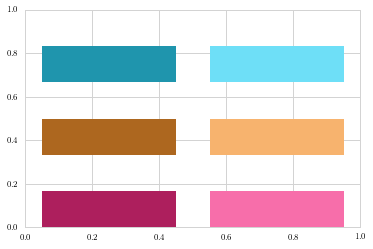

In [179]:
from matplotlib.patches import Rectangle
from seaborn import set_hls_values

fig, ax = plt.subplots()
color_cycle = ax._get_lines.prop_cycler

cs = [next(color_cycle)["color"] for i in range(3)]
cs = [set_hls_values(c, l = 0.4, s = 0.7) for c in cs]
cs_bright = [set_hls_values(c, l = 0.7, s = 0.9) for c in cs]

for i, c in enumerate(cs):
    h = 1.0 / (2 * len(cs))
    r = Rectangle((0.05, i * 2 * h), 0.4, h, facecolor = c)
    ax.add_artist(r)
    
for i, c in enumerate(cs_bright):
    h = 1.0 / (2 * len(cs))
    r = Rectangle((0.55, i * 2 * h), 0.4, h, facecolor = c)
    ax.add_artist(r)
    
colors = []
for i in range(3):
    colors += [cs[i]]
    colors += [cs_bright[i]]

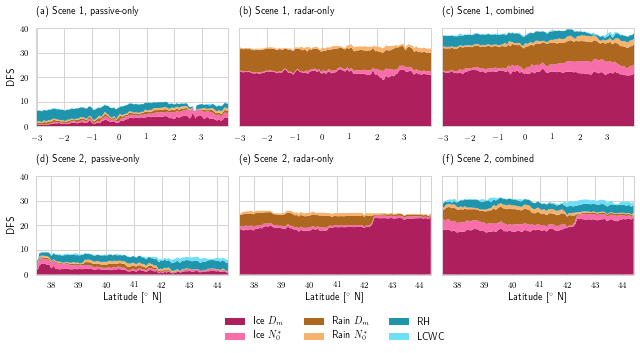

In [183]:
from seaborn import desaturate
from scipy.signal import convolve

f = plt.figure(figsize = (9, 5))
gs = GridSpec(3, 3, height_ratios = [1.0, 1.0, 0.1])
k = np.ones(10) / 10

ics = [ic_a_po, ic_a_ro, ic_a]

x = convolve(reference_a["lat"], k, "valid")
qs = ["ice_dm", "ice_n0", "rain_dm", "rain_n0", "h2o", "cw"]
labels = ["Ice $D_m$",
          "Ice $N^*_0$",
          "Rain $D_m$",
          "Rain $N^*_0$",
          "RH",
          "LCWC"]
rts = ["passive-only", "radar-only", "combined"]

for i in range(3):
    ax = plt.subplot(gs[0, i])
    ys = np.zeros(x.size)
    for j, q in enumerate(qs):
        c = desaturate(ax._get_lines.get_next_color(), 0.8)
        c = colors[j]
        y = convolve(k, ics[i][q], "valid")
        ax.fill_between(x, ys, ys + y, facecolor = c, edgecolor = "w", lw = 0)
        ys += y
        
    if i == 0:
        ax.set_ylabel("DFS")
    else:
        ax.set_yticklabels([])
    
    ax.set_ylim([0, 40])
    ax.set_xlim(x[[0, -1]])
    ax.set_title("({}) Scene 1, {}".format(chr(ord("a") + i), rts[i]), loc = "left")
        
x = convolve(reference_b["lat"], k, "valid")
ics = [ic_b_po, ic_b_ro, ic_b]
for i in range(3):
    handles = []
    ax = plt.subplot(gs[1, i])
    ys = np.zeros(x.size)
    for j,q in enumerate(qs):
        c = desaturate(ax._get_lines.get_next_color(), 0.8)
        c = colors[j]
        y = convolve(k, ics[i][q], "valid")
        handles += [ax.fill_between(x, ys, ys + y, facecolor = c)]
        ys += y
        
    ax.set_xlabel(r"Latitude [$^\circ \ \text{N}$]")
    if i == 0:
        ax.set_ylabel("DFS")
    else:
        ax.set_yticklabels([])
    
    ax.set_ylim([0, 40])
    ax.set_xlim(x[[0, -1]])
    ax.set_title("({}) Scene 2, {}".format(chr(ord("d") + i), rts[i]), loc = "left")

ax = plt.subplot(gs[-1, :])
ax.set_axis_off()
ax.legend(handles = handles, labels = labels, ncol = 3, loc = "center")
plt.tight_layout()
f.savefig("../../plots/dfs.pdf", bbox_inches = "tight")

## OEM cost and misfit

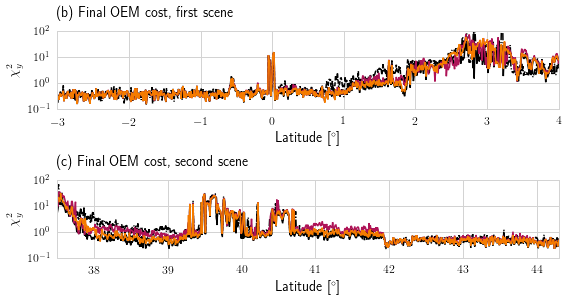

In [187]:
import sys
sys.path.append("/home/simonpf/src/ssdb")
import ssdb

eca = getattr(ssdb, "8-ColumnAggregate")
lpa = getattr(ssdb, "LargePlateAggregate")
pt1 = getattr(ssdb, "PlateType1")
gg  = getattr(ssdb, "GemGraupel")

from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize = (8, 5))
gs = GridSpec(3, 1, height_ratios = [1.0, 1.0, 0.2])

#
# OEM cost
#

hs = ["GemCloudIce_None",
      "GemSnow_None",
      "GemGraupel_None",
      "LargePlateAggregate_None",
      "IconSnow_None"]

ax = plt.subplot(gs[0, 0])
cs = ["k", "k", "k", "C0", "C1"]
lss = ["-.", "-", "--", "-", "-"]

for h, c, ls in zip(hs, cs, lss):
    lats = reference_a["lat"]
    y = results_a[h]["diagnostics"][:, 2]
    y = np.convolve(y, np.ones(1) / 1.0, mode = "valid")
    x = np.convolve(lats, np.ones(1) / 1.0, mode = "valid")
    ax.plot(x, y, alpha = 1.0, c = c, ls = ls, lw = 1.5)
    ax.set_ylim([1e-1, 100])
    
ax.set_yscale("log")
ax.set_ylabel("$\chi^2_y$", fontsize = 14)
ax.set_xlabel("Latitude [$^\circ$]", fontsize = 14)
ax.set_xlim([-3, 4])

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)


ax.set_title("(b) Final OEM cost, first scene", loc = "left", fontsize = 14)

#
# OEM cost
#

ax = plt.subplot(gs[1, :])

for h, c, ls in zip(hs, cs, lss):
    lats = reference_b["lat"]
    y = results_b[h]["diagnostics"][:, 2]
    y[y.mask] = 0.0
    y = np.convolve(y, np.ones(1) / 1.0, mode = "valid")
    x = np.convolve(lats, np.ones(1) / 1.0, mode = "valid")
    ax.plot(x, y, alpha = 1.0, c = c, ls = ls, lw = 1.5)
    ax.set_ylim([1e-1, 100])
    
ax.set_yscale("log")
ax.set_xlabel("Latitude [$^\circ$]", fontsize = 14)
ax.set_xlim([37.5, 44.3])

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)


ax.set_title("(c) Final OEM cost, second scene", loc = "left", fontsize = 14)
ax.set_ylabel("$\chi^2_y$", fontsize = 14)

plt.tight_layout()
fig.savefig("../../plots/costs.pdf", bbox_inches = "tight")

0
1
0
1
0
1


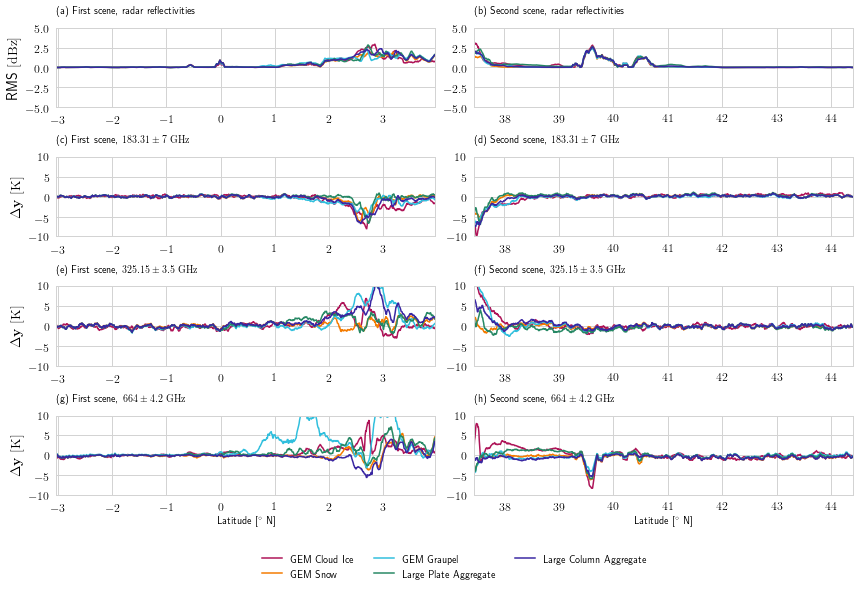

In [188]:
import sys
sys.path.append("/home/simonpf/src/ssdb")
from scipy.signal import convolve
import ssdb

eca = getattr(ssdb, "8-ColumnAggregate")
lpa = getattr(ssdb, "LargePlateAggregate")
pt1 = getattr(ssdb, "PlateType1")
gg  = getattr(ssdb, "GemGraupel")

from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize = (12, 8))
gs = GridSpec(5, 2, height_ratios = [1.0, 1.0, 1.0, 1.0, 0.2])

hs = ["GemCloudIce_None", "GemSnow_None", "GemGraupel_None", "LargePlateAggregate_None", "IconSnow_None"]
cs = ["C0", "C1", "C2", "C3", "C5"]
lss = ["-", "-", "-", "-", "-"]

k = np.ones(10) / 10.0
#
# Radar
#

rs = [results_a, results_b]
rf = [reference_a, reference_b]

for i in range(2):
    ax = plt.subplot(gs[0, i])

    for h, c, ls in zip(hs, cs, lss):
        x = rf[i]["lat"]
        yf = rs[i][h]["yf_lcpr"][:, :]
        y = rs[i][h]["y_lcpr"][:, :]
        dy = yf - y
        dy = np.std(dy, axis = -1)

        x = np.convolve(x, k, "valied")
        dy = np.convolve(dy, k, "valied")
        
        ax.plot(x, dy, alpha = 1.0, c = c, ls = ls, lw = 1.5)

    if i == 0:
        ax.set_ylabel(r"$\text{RMS}\  [\unit{dBz}]$", fontsize = 14)
    
    ax.set_ylim([-5, 5])
    ax.set_xlim(x[[0, -1]])
    if i == 0:
        ax.set_title("({}) First scene, radar reflectivities".format(chr(ord("a") + 0)), loc = "left")
    else:
        ax.set_title("({}) Second scene, radar reflectivities".format(chr(ord("a") + 1)), loc = "left")

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12)
        
#
# Passive channels
#

scene = ["First", "Second"]
freqs = ["183.31 \pm 7", "325.15 \pm 3.5", "664 \pm 4.2"]

rs = [results_a, results_b]
cis = [0, 5, 10]

for i, ci in enumerate(cis):
    for j in range(2):
        print(j)
        ax = plt.subplot(gs[i + 1, j])

        handles = []
        for h, c, ls in zip(hs, cs, lss):
            x = rf[j]["lat"]
            yf = rs[j][h]["yf_ici"][:, ci]
            y = rs[j][h]["y_ici"][:, ci]
            dy = yf - y
            
            x = np.convolve(x, k, "valied")
            dy = np.convolve(dy, k, "valied")
            
            handles += ax.plot(x, dy, alpha = 1.0, c = c, ls = ls, lw = 1.5)

        if j == 0:
            ax.set_ylabel(r"$\Delta \mathbf{y}\ [\unit{K}]$", fontsize = 14)


        ax.set_ylim([-10, 10])
                
        ax.set_xlim(x[[0, -1]])
        ax.set_title(r"({}) {} scene, ${}\ \unit{{GHz}}$".format(chr(ord("a") + (i + 1) * 2 + j), scene[j], freqs[i]),
                     loc = "left") 
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(12)

        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(12)
        if i == len(cis) - 1:
            ax.set_xlabel(r"Latitude [$^\circ \ \text{N}$]")            
plt.tight_layout()

labels = ["GEM Cloud Ice", "GEM Snow", "GEM Graupel", "Large Plate Aggregate", "Large Column Aggregate"]
ax = plt.subplot(gs[-1, :])
ax.set_axis_off()
ax.legend(handles = handles, labels = labels, loc = "upper center", ncol = 3)

fig.savefig("../../plots/misfits.pdf", bbox_inches = "tight")

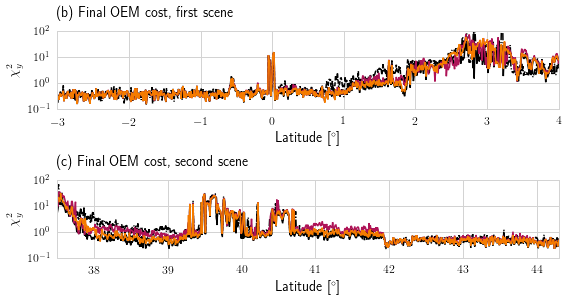

In [189]:
import sys
sys.path.append("/home/simonpf/src/ssdb")
import ssdb

eca = getattr(ssdb, "8-ColumnAggregate")
lpa = getattr(ssdb, "LargePlateAggregate")
pt1 = getattr(ssdb, "PlateType1")
gg  = getattr(ssdb, "GemGraupel")

from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize = (8, 5))
gs = GridSpec(3, 1, height_ratios = [1.0, 1.0, 0.2])

#
# OEM cost
#

hs = ["GemCloudIce_None",
      "GemSnow_None",
      "GemGraupel_None",
      "LargePlateAggregate_None",
      "IconSnow_None"]

ax = plt.subplot(gs[0, 0])
cs = ["k", "k", "k", "C0", "C1"]
lss = ["-.", "-", "--", "-", "-"]

for h, c, ls in zip(hs, cs, lss):
    lats = reference_a["lat"]
    y = results_a[h]["diagnostics"][:, 2]
    y = np.convolve(y, np.ones(1) / 1.0, mode = "valid")
    x = np.convolve(lats, np.ones(1) / 1.0, mode = "valid")
    ax.plot(x, y, alpha = 1.0, c = c, ls = ls, lw = 1.5)
    ax.set_ylim([1e-1, 100])
    
ax.set_yscale("log")
ax.set_ylabel("$\chi^2_y$", fontsize = 14)
ax.set_xlabel("Latitude [$^\circ$]", fontsize = 14)
ax.set_xlim([-3, 4])

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)


ax.set_title("(b) Final OEM cost, first scene", loc = "left", fontsize = 14)

#
# OEM cost
#

ax = plt.subplot(gs[1, :])

for h, c, ls in zip(hs, cs, lss):
    lats = reference_b["lat"]
    y = results_b[h]["diagnostics"][:, 2]
    y[y.mask] = 0.0
    y = np.convolve(y, np.ones(1) / 1.0, mode = "valid")
    x = np.convolve(lats, np.ones(1) / 1.0, mode = "valid")
    ax.plot(x, y, alpha = 1.0, c = c, ls = ls, lw = 1.5)
    ax.set_ylim([1e-1, 100])
    
ax.set_yscale("log")
ax.set_xlabel("Latitude [$^\circ$]", fontsize = 14)
ax.set_xlim([37.5, 44.3])

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)


ax.set_title("(c) Final OEM cost, second scene", loc = "left", fontsize = 14)
ax.set_ylabel("$\chi^2_y$", fontsize = 14)

plt.tight_layout()
fig.savefig("../../plots/costs.pdf", bbox_inches = "tight")

## S

In [190]:
from mcrf.liras.results import plot_results
def iwc(n0, dm):
    return np.pi * 917.0 * dm ** 4 * n0 / 4 ** 4

In [191]:
qs_a = {}
qs_a_ro = {}
qs_a_po = {}
qs_a_r1 = {}

xx  = np.broadcast_to(lats.reshape(-1, 1), reference_a["iwc"].shape)
q_r = np.maximum(reference_a["iwc"] + reference_a["swc"] + reference_a["hwc"] + reference_a["gwc"], 1e-8)


hs = [k for k in results_a.keys() if "None" in k]
for h in hs:
    rs = results_a[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    fe   = np.abs(q - q_r) / q_r
    inds = np.logical_or(q_r > 1e-6, q > 1e-6)
    qs_a[h] = (q_r.ravel(), q.ravel())

    rs = results_a_ro[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    fe   = np.abs(q - q_r) / q_r
    inds = np.logical_or(q_r > 1e-6, q > 1e-6)
    qs_a_ro[h] = (q_r.ravel(), q.ravel())

    rs = results_a_r1[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    fe   = np.abs(q - q_r) / q_r
    inds = np.logical_or(q_r > 1e-6, q > 1e-6)
    qs_a_r1[h] = (q_r.ravel(), q.ravel())
    
    rs = results_a_po[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    fe   = np.abs(q - q_r) / q_r
    inds = np.logical_or(q_r > 1e-6, q > 1e-6)
    qs_a_po[h] = (q_r.ravel(), q.ravel())

In [192]:
qs_b = {}
qs_b_ro = {}
qs_b_po = {}
qs_b_r1 = {}

xx  = np.broadcast_to(lats.reshape(-1, 1), reference_b["iwc"].shape)
q_r = np.maximum(reference_b["iwc"] + reference_b["swc"] + reference_b["hwc"] + reference_b["gwc"], 1e-8)

for h in hs:
    rs = results_b[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    fe   = np.abs(q - q_r) / q_r
    inds = np.logical_or(q_r > 1e-5, q > 1e-5)
    qs_b[h] = (q_r.ravel(), q.ravel())

    rs = results_b_ro[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    fe   = np.abs(q - q_r) / q_r
    inds = np.logical_or(q_r > 1e-5, q > 1e-5)
    qs_b_ro[h] = (q_r.ravel(), q.ravel())
    
    rs = results_b_r1[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    fe   = np.abs(q - q_r) / q_r
    inds = np.logical_or(q_r > 1e-5, q > 1e-5)
    qs_b_r1[h] = (q_r.ravel(), q.ravel())
    
    rs = results_b_po[h]
    q    = iwc(rs["ice_n0"], rs["ice_dm"]).data
    fe   = np.abs(q - q_r) / q_r
    inds = np.logical_or(q_r > 1e-5, q > 1e-5)
    qs_b_po[h] = (q_r.ravel(), q.ravel())

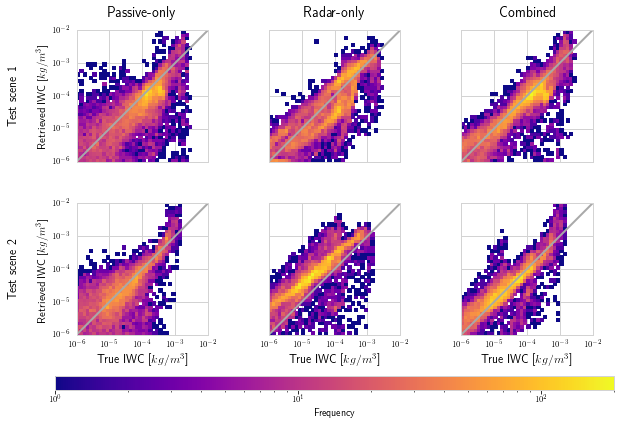

In [193]:
from matplotlib.colors   import LogNorm
from matplotlib.image    import imread
from matplotlib.cm import ScalarMappable

n  = 2
f  = plt.figure(figsize = (9, n * 3))
gs = GridSpec(n + 1, 3, width_ratios = [1.0, 1.0, 1.0], height_ratios = [1.0] * n + [0.1])
norm = LogNorm(1, 200)
h = "LargePlateAggregate_None"

# Colorbar
sm = ScalarMappable(norm = norm, cmap = "plasma")
sm.set_array(np.linspace(0, 100, 101))
ax = plt.subplot(gs[-1, :])
plt.colorbar(sm, orientation = "horizontal", label = "Frequency", cax = ax)

#
# Habit types
#

# Scatter plot
for j, q in enumerate([qs_a_po, qs_a_ro, qs_a]):
    
    ax = plt.subplot(gs[0, j])
    x, y = q[h]
    bins = np.logspace(-6, -2, 41)
    img, x, y = np.histogram2d(x, y, bins)
    ax.pcolormesh(x, y, img.T, cmap = "plasma", norm = norm)
    plt.grid(zorder = 0)
        
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([1e-6, 1e-2])
    ax.set_ylim([1e-6, 1e-2])
    ax.set_aspect(1)
    
    x = np.logspace(-6, -2, 101)
    ax.plot(x, x, lw = 2, c = "darkgray")
    
    if j > 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Retrieved IWC [$kg / m^3$]", fontsize = 11)
        
    ax.set_xticklabels([])
        
    titles = ["Passive-only", "Radar-only", "Combined"]
    ax.set_title(titles[j], fontsize = 14)
    
    if j == 0:
        col = "Test scene 1"
        ax.annotate(col, xy=(0.0, 0.5),
                    xytext=(- ax.yaxis.labelpad - 60, 0),
                    xycoords='axes fraction',
                    textcoords='offset points',
                    rotation = 90,
                    fontsize = 14,
                    size='large', ha='center',
                    va='center')
            
# Scatter plot
for j, q in enumerate([qs_b_po, qs_b_ro, qs_b]):
    ax = plt.subplot(gs[1, j])
    x, y = q[h]
    bins = np.logspace(-6, -2, 41)
    img, x, y = np.histogram2d(x, y, bins)
    ax.pcolormesh(x, y, img.T, cmap = "plasma", norm = norm)
    plt.grid(zorder = 0)
        
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([1e-6, 1e-2])
    ax.set_ylim([1e-6, 1e-2])
    ax.set_aspect(1)
    
    x = np.logspace(-6, -2, 101)
    ax.plot(x, x, lw = 2, c = "darkgray")
    
    if j > 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Retrieved IWC [$kg / m^3$]", fontsize = 11)
        
    ax.set_xlabel("True IWC [$kg / m^3$]", fontsize = 12)
    
    if j == 0:
        col = "Test scene 2"
        ax.annotate(col, xy=(0.0, 0.5),
                    xytext=(- ax.yaxis.labelpad - 60, 0),
                    xycoords='axes fraction',
                    textcoords='offset points',
                    rotation = 90,
                    fontsize = 14,
                    size='large', ha='center',
                    va='center')
        
plt.tight_layout()

f.savefig("../../plots/results_hist.png", dpi = 500)

## Box plots

### Data frames

In [198]:
import pandas as pd
data = {}
hs = [k for k in results_a.keys() if "None" in k]
z_a = reference_a["z"]
z_b = reference_b["z"]

retrieval_types = []
particle_names = []
quantities = []
scenes = []
errors = np.zeros(0)

for t, rs in zip(["Passive-only", "Radar-only", "Radar-only (1M)", "Combined"],
                [qs_a_po, qs_a_ro, qs_a_r1, qs_a]):
    for h in hs:
        q_r, q = rs[h]
        name = h[:-5]
        
        es = 10.0 * np.log10(q / q_r)
        #inds = q_r > 1e-6
        inds = q_r > 1e-6 #np.logical_or(q > 1e-5, q_r > 1e-5) #q_r > 1e-6 #np.logical_or(q > 1e-6, q_r > 1e-6)
        es = es[inds]
        
        retrieval_types += [t] * es.size
        particle_names += [name] * es.size
        quantities += ["IWC"] * es.size
        scenes += ["A"] * es.size
        errors = np.concatenate([errors, es])
        
        # Column-integrated
        q_r = np.trapz(q_r.reshape(800, 58), x = z_a)
        q   = np.trapz(q.reshape(800, 58), x = z_a)
        es = 10.0 * np.log10(q / q_r)
        es = es.ravel()
        
        retrieval_types += [t] * es.size
        particle_names += [name] * es.size
        quantities += ["IWP"] * es.size
        scenes += ["A"] * es.size
        errors = np.concatenate([errors, es])
        
        
for t, rs in zip(["Passive-only", "Radar-only", "Radar-only (1M)", "Combined"],
                [qs_b_po, qs_b_ro, qs_b_r1, qs_b]):
    for h in hs:
        q_r, q = rs[h]
        name = h[:-5]
        
        es = 10.0 * np.log10(q / q_r)
        inds = np.logical_or(q > 1e-5, q_r > 1e-5) #q_r > 1e-6 #np.logical_or(q > 1e-6, q_r > 1e-6)
        es = es[inds]
        
        retrieval_types += [t] * es.size
        particle_names += [name] * es.size
        quantities += ["IWC"] * es.size
        scenes += ["B"] * es.size
        errors = np.concatenate([errors, es])
        
        # Column-integrated
        q_r = np.trapz(q_r.reshape(800, 58), x = z_b)
        q   = np.trapz(q.reshape(800, 58), x = z_b)
        es = 10.0 * np.log10(q / q_r)
        es = es.ravel()
        
        retrieval_types += [t] * es.size
        particle_names += [name] * es.size
        quantities += ["IWP"] * es.size
        scenes += ["B"] * es.size
        errors = np.concatenate([errors, es])
        
data = pd.DataFrame({"Retrieval type" : retrieval_types,
                    "Particle name" : particle_names,
                    "Quantity" : quantities,
                    "Scene" : scenes,
                    "Error" : errors})

In [199]:
import seaborn as sns
sns.reset_defaults()

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


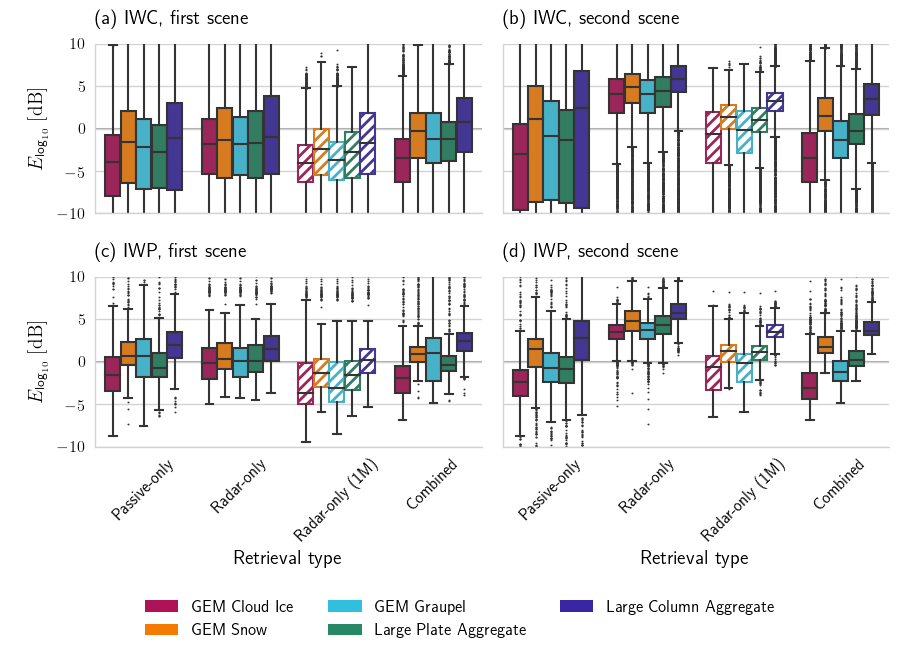

In [200]:
import matplotlib as mpl
import matplotlib.patches as patches
plt.style.use("../../mcrf/utils/style")
mpl.rcParams['hatch.linewidth'] = 2.0  # previous svg hatch linewidth
hatch = "." * 2
hatches = ["//", "-", "."]

colors = {"GemCloudIce" : "white",
          "GemSnow" : 'white',
          "GemGraupel" : "white",
          "LargePlateAggregate" : '#ae1357',
          "LargeColumnAggregate" : '#f47b00'}
colors = {"GemCloudIce" : "C0",
          "GemSnow" : "C1",
          "GemGraupel" : "C2",
          "LargePlateAggregate" : "C3",
          "LargeColumnAggregate" : "C5"}


order = ["GemCloudIce", "GemSnow", "GemGraupel", "LargePlateAggregate", "LargeColumnAggregate"]
fg = sns.catplot(x = "Retrieval type", y = "Error", hue = "Particle name", col = "Scene",
                 data = data, row = "Quantity", kind = "box", showfliers = True, fliersize = 0.5,
                 palette = colors, hue_order = order, aspect = 1.5, height = 3, legend= False, whis = 1.5)

titles = [["(a) IWC, first scene", "(b) IWC, second scene"],
          ["(c) IWP, first scene", "(d) IWP, second scene"]]
for i in range(2):
    for j in range(2):
        ax = fg.axes[i, j]
        ax.set_ylim([-10, 10])
        for k, artist in enumerate(ax.artists):
            if (k < 15) and (k >= 10):
                c = artist.get_facecolor()
                artist.set_facecolor("w")
                artist.set_hatch("///")
                artist.set_edgecolor(c)
                
        if j == 0:
            ax.set_ylabel(r"$E_{\text{log}_{10}}\ [\unit{dB}]$")
            
        ax.axhline(0.0, c = "darkgrey", ls = "-", zorder = -2)
        ax.set_title("")
        ax.set_title(titles[i][j], loc = "left")
        
        if i == 1:
            labels = ax.get_xticklabels()
            ax.set_xticklabels(labels, rotation = 45)
        
            
#legend
handles = [patches.Patch(facecolor = colors["GemCloudIce"], label = "GEM Cloud Ice"),
           patches.Patch(facecolor = colors["GemSnow"], label = "GEM Snow"),
           patches.Patch(facecolor = colors["GemGraupel"], label = "GEM Graupel"),
           patches.Patch(facecolor = colors["LargePlateAggregate"], label = "Large Plate Aggregate"),
           patches.Patch(facecolor = colors["LargeColumnAggregate"], label = "Large Column Aggregate")]
labels = list(colors.keys())
           
lax = plt.axes([0.0, -0.1, 1.0, 0.1])    
lax.legend(handles = handles, loc = "center", ncol = 3, frameon = False, fontsize = 12)
lax.set_axis_off()
plt.tight_layout()
plt.gcf().savefig("../../plots/results_box.pdf", bbox_inches = "tight")

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


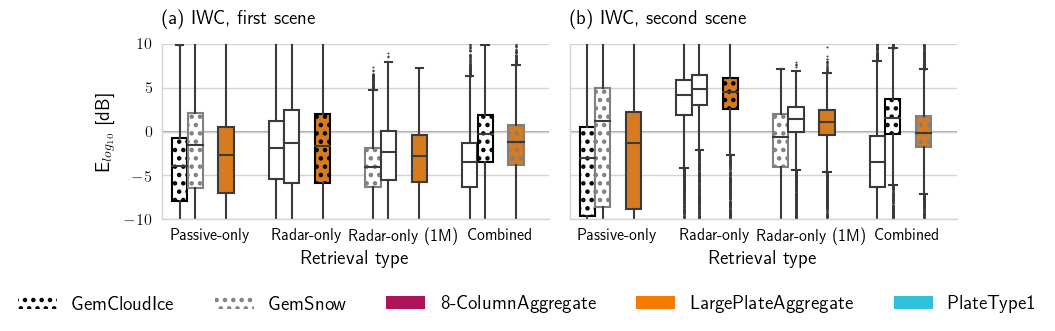

In [202]:
import matplotlib as mpl
import matplotlib.patches as patches
mpl.rcParams['hatch.linewidth'] = 2.0  # previous svg hatch linewidth
hatch = "." * 2
colors = {"GemCloudIce" : "white",
          "GemSnow" : "white",
          "8-ColumnAggregate" : '#ae1357',
          "LargePlateAggregate" : '#f47b00',
          "PlateType1" : '#30bfdd'}

data_iwc = data.loc[data.Quantity == "IWC"]
order = ["GemCloudIce", "GemSnow", "8-ColumnAggregate", "LargePlateAggregate", "PlateType1"]
fg = sns.catplot(x = "Retrieval type", y = "Error", hue = "Particle name", col = "Scene",
                 data = data_iwc, row = "Quantity", kind = "box", showfliers = True, fliersize = 0.5,
                 palette = colors, hue_order = order, aspect = 1.5, height = 3, legend= False, whis = 1.5)

titles = [["(a) IWC, first scene", "(b) IWC, second scene"],
          ["(c) IWP, first scene", "(d) IWP, second scene"]]
for i in range(1):
    for j in range(2):
        ax = fg.axes[i, j]
        ax.set_ylim([-10, 10])
        for k, artist in enumerate(ax.artists):
            if (k % 5) == 0:
                artist.set_hatch(hatch)
                artist.set_edgecolor("k")
            if (k % 5) == 1:
                artist.set_hatch(hatch)
                artist.set_edgecolor("grey")
                
        if j == 0:
            ax.set_ylabel("E$_{log_{10}}$ [dB]")
            
        ax.axhline(0.0, c = "darkgrey", ls = "-", zorder = -2)
        ax.set_title("")
        ax.set_title(titles[i][j], loc = "left")
        
            
#legend
handles = [patches.Patch(facecolor = colors["GemCloudIce"], edgecolor = "k", hatch = hatch, label = "GemCloudIce"),
           patches.Patch(facecolor = colors["GemSnow"], edgecolor = "grey", hatch = hatch, label = "GemSnow"),
           patches.Patch(facecolor = colors["8-ColumnAggregate"], label = "8-ColumnAggregate"),
           patches.Patch(facecolor = colors["LargePlateAggregate"], label = "LargePlateAggregate"),
           patches.Patch(facecolor = colors["PlateType1"], label = "PlateType1")]
labels = list(colors.keys())
           
lax = plt.axes([0.0, -0.1, 1.0, 0.1])    
lax.legend(labels = labels, handles = handles, loc = "center", ncol = 5, frameon = False)
lax.set_axis_off()
plt.tight_layout()
plt.gcf().savefig("../../plots/results_box_iwc.pdf", bbox_inches = "tight")

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


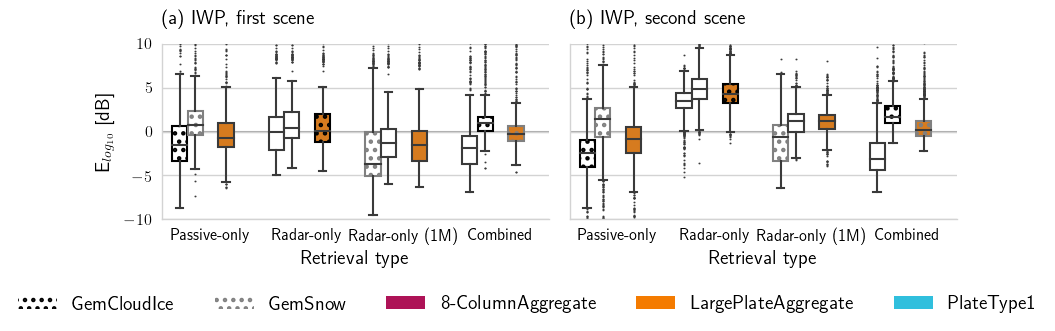

In [203]:
import matplotlib as mpl
import matplotlib.patches as patches
mpl.rcParams['hatch.linewidth'] = 2.0  # previous svg hatch linewidth
hatch = "." * 2
colors = {"GemCloudIce" : "white",
          "GemSnow" : "white",
          "8-ColumnAggregate" : '#ae1357',
          "LargePlateAggregate" : '#f47b00',
          "PlateType1" : '#30bfdd'}

data_iwc = data.loc[data.Quantity == "IWP"]
order = ["GemCloudIce", "GemSnow", "8-ColumnAggregate", "LargePlateAggregate", "PlateType1"]
fg = sns.catplot(x = "Retrieval type", y = "Error", hue = "Particle name", col = "Scene",
                 data = data_iwc, row = "Quantity", kind = "box", showfliers = True, fliersize = 0.5,
                 palette = colors, hue_order = order, aspect = 1.5, height = 3, legend= False, whis = 1.5)

titles = [["(a) IWP, first scene", "(b) IWP, second scene"]]
for i in range(1):
    for j in range(2):
        ax = fg.axes[i, j]
        ax.set_ylim([-10, 10])
        for k, artist in enumerate(ax.artists):
            if (k % 5) == 0:
                artist.set_hatch(hatch)
                artist.set_edgecolor("k")
            if (k % 5) == 1:
                artist.set_hatch(hatch)
                artist.set_edgecolor("grey")
                
        if j == 0:
            ax.set_ylabel("E$_{log_{10}}$ [dB]")
            
        ax.axhline(0.0, c = "darkgrey", ls = "-", zorder = -2)
        ax.set_title("")
        ax.set_title(titles[i][j], loc = "left")
        
            
#legend
handles = [patches.Patch(facecolor = colors["GemCloudIce"], edgecolor = "k", hatch = hatch, label = "GemCloudIce"),
           patches.Patch(facecolor = colors["GemSnow"], edgecolor = "grey", hatch = hatch, label = "GemSnow"),
           patches.Patch(facecolor = colors["8-ColumnAggregate"], label = "8-ColumnAggregate"),
           patches.Patch(facecolor = colors["LargePlateAggregate"], label = "LargePlateAggregate"),
           patches.Patch(facecolor = colors["PlateType1"], label = "PlateType1")]
labels = list(colors.keys())
           
lax = plt.axes([0.0, -0.1, 1.0, 0.1])    
lax.legend(labels = labels, handles = handles, loc = "center", ncol = 5, frameon = False)
lax.set_axis_off()
plt.tight_layout()
plt.gcf().savefig("../../plots/results_box_iwp.pdf", bbox_inches = "tight")